<a href="https://colab.research.google.com/github/EmelyanovAndreyNSK/PythonProjects/blob/master/Petro_GM_comparison_TIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ruptures as rpt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import warnings
import time, copy
import pandas as pd


In [ ]:
def distance(data, window_size):
    """
    Calculates distance (dissimilarity measure) between features
    
    Args:
        data: array of of learned features of size (nr. of windows) x (number of shared features)
        window_size: window size used for CPD
        
    Returns:
        Array of dissimilarities of size ((nr. of windows)-stride)
    """
    
    nr_windows = np.shape(data)[0]
    
    index_1 = range(window_size,nr_windows,1)
    index_2 = range(0,nr_windows-window_size,1)
    
    return np.sqrt(np.sum(np.square(data[index_1]-data[index_2]),1))

def parameters_to_cps(parameters,window_size):
    """
    Preparation for plotting ground-truth change points
    
    Args:
        parameters: array parameters used to generate time series, size Tx(nr. of parameters)
        window_size: window size used for CPD
        
    Returns:
        Array of which entry is non-zero in the presence of a change point. Higher values correspond to larger parameter changes.
    """
    
    length_ts = np.size(parameters,0)
        
    index1 = range(window_size-1,length_ts-window_size,1) #selects parameter at LAST time stamp of window
    index2 = range(window_size,length_ts-window_size+1,1) #selects parameter at FIRST time stamp of next window

    diff_parameters = np.sqrt(np.sum(np.square(parameters[index1]-parameters[index2]),1))
    
    max_diff = np.max(diff_parameters)
    
    return diff_parameters/max_diff

def cp_to_timestamps(changepoints, tolerance, length_ts):
    """
    Extracts time stamps of change points
    
    Args:
        changepoints:
        tolerance:
        length_ts: length of original time series
        
    Returns:
        list where each entry is a list with the windows affected by a change point
    """
    
    locations_cp = [idx for idx, val in enumerate(changepoints) if val > 0.0]
    
    output = []
    while len(locations_cp)>0:
        k = 0
        for i in range(len(locations_cp)-1):
            if  locations_cp[i]+1 == locations_cp[i+1]:
                k+=1
            else:
                break
        
        output.append(list(range(max(locations_cp[0]-tolerance,0),min(locations_cp[k]+1+tolerance,length_ts),1)))
        del locations_cp[:k+1]
        
    return output

def ts_to_windows(ts, onset, window_size, stride, normalization="timeseries"):
    """Transforms time series into list of windows"""
    windows = []
    len_ts = len(ts)
    onsets = range(onset, len_ts-window_size+1, stride)
    
    if normalization =="timeseries":
        for timestamp in onsets:
            windows.append(ts[timestamp:timestamp+window_size])
    elif normalization=="window":
        for timestamp in onsets:
            windows.append(np.array(ts[timestamp:timestamp+window_size])-np.mean(ts[timestamp:timestamp+window_size]))
            
    return np.array(windows)

def combine_ts(list_of_windows):
    """
    Combines a list of windows from multiple views to one list of windows
    
    Args:
        list_of_windows: list of windows from multiple views
        
    Returns:
        one array with the concatenated windows
    """
    nr_ts, nr_windows, window_size = np.shape(list_of_windows)
    tss = np.array(list_of_windows)
    new_ts = []
    for i in range(nr_windows):
        new_ts.append(tss[:,i,:].flatten())
    return np.array(new_ts)

def new_peak_prominences(distances):
    """
    Adapted calculation of prominence of peaks, based on the original scipy code
    
    Args:
        distances: dissimarity scores
    Returns:
        prominence scores
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        all_peak_prom = peak_prominences(distances,range(len(distances)))
    return all_peak_prom

def tpr_fpr(bps,distances, method="prominence",tol_dist=0):
    """Calculation of TPR and FPR
    
    Args:
        bps: list of breakpoints (change points)
        distances: list of dissimilarity scores
        method: prominence- or height-based change point score
        tol_dist: toleration distance
        
    Returns:
        list of TPRs and FPRs for different values of the detection threshold
    """
    
    peaks = find_peaks(distances)[0]
    peaks_prom = peak_prominences(distances,peaks)[0]
    peaks_prom_all = np.array(new_peak_prominences(distances)[0])
    distances = np.array(distances)
        
    bps = np.array(bps)
        
    if method == "prominence":
        
        nr_bps = len(bps)
        
        index_closest_peak = [0]*nr_bps
        bp_detected = [0]*nr_bps
        
        #determine for each bp the allowed range s.t. alarm is closest to bp
        
        ranges = [0] * nr_bps
        
        for i in range(nr_bps):
            
            if i==0:
                left = 0
            else:
                left = right
            if i==(nr_bps-1):
                right = len(distances)
            else:
                right = int((bps[i][-1]+bps[i+1][0])/2)+1
                
            ranges[i] = [left,right]
        
        quantiles = np.quantile(peaks_prom,np.array(range(51))/50)
        quantiles_set = set(quantiles)
        quantiles_set.add(0.)
        quantiles = list(quantiles_set)
        quantiles.sort()
        
        nr_quant = len(quantiles)
        
        ncr = [0.]*nr_quant
        nal = [0.]*nr_quant
        
        for i in range(nr_quant):
            for j in range(nr_bps):
                
                bp_nbhd = peaks_prom_all[max(bps[j][0]-tol_dist,ranges[j][0]):min(bps[j][-1]+tol_dist+1,ranges[j][1])]
                
                if max(bp_nbhd) >= quantiles[i]:
                    ncr[i] += 1
                            
            indices_all = np.array(range(len(distances)))
            heights_alarms = distances[peaks_prom_all>=quantiles[i]]
            nal[i] = len(heights_alarms)
                    
        ncr = np.array(ncr)
        nal = np.array(nal)
        
        ngt = nr_bps
        
        tpr = ncr/ngt
        fpr = (nal-ncr)/nal
        
        tpr = list(tpr[nal!=0])
        fpr = list(fpr[nal!=0])
        
        tpr.insert(0,1.0)
        fpr.insert(0,1.0)
        tpr.insert(len(tpr),0.0)
        fpr.insert(len(fpr),0.0)
    return tpr, fpr

def matched_filter(signal, window_size):
    """
    Matched filter for dissimilarity measure smoothing (and zero-delay weighted moving average filter for shared feature smoothing)
    
    Args:
        signal: input signal
        window_size: window size used for CPD
    Returns:
        filtered signal
    """
    mask = np.ones((2*window_size+1,))
    for i in range(window_size):
        mask[i] = i/(window_size**2)
        mask[-(i+1)] = i/(window_size**2)
    mask[window_size] = window_size/(window_size**2)
        
    signal_out = np.zeros(np.shape(signal))
    
    if len(np.shape(signal)) >1:
        for i in range(np.shape(signal)[1]):
            signal_extended = np.concatenate((signal[0,i]*np.ones(window_size), signal[:,i], signal[-1,i]*np.ones(window_size)))
            signal_out[:,i] = np.convolve(signal_extended, mask, 'valid')
    else:
        signal = np.concatenate((signal[0]*np.ones(window_size), signal, signal[-1]*np.ones(window_size)))
        signal_out = np.convolve(signal, mask, 'valid')
    
    return signal_out

def minmaxscale(data, a, b):
    """
    Scales data to the interval [a,b]
    """
    data_min = np.amin(data)
    data_max = np.amax(data)
        
    return (b-a)*(data-data_min)/(data_max-data_min)+a

def calc_fft(windows, nfft=30, norm_mode="timeseries"):
    """
    Calculates the DFT for each window and transforms its length
    
    Args:
        windows: time series windows
        nfft: number of points used for the calculation of the DFT
        norm_mode: ensure that the timeseries / each window has zero mean
        
    Returns:
        frequency domain windows, each window having size nfft//2 (+1 for timeseries normalization)
    """
    mean_per_segment = np.mean(windows, axis=-1)
    mean_all = np.mean(mean_per_segment, axis=0)
    
    if norm_mode == "window":
        windows = windows-mean_per_segment[:,None]
        windows_fft = abs(np.fft.fft(windows, nfft))[...,1:nfft//2+1]
    elif norm_mode == "timeseries":
        windows = windows-mean_all
        windows_fft = abs(np.fft.fft(windows, nfft))[...,:nfft//2+1]
        
    
    fft_max = np.amax(windows_fft)
    fft_min = np.amin(windows_fft)
        
    windows_fft = 2*(windows_fft-fft_min)/(fft_max-fft_min)-1
    
    return windows_fft

def plot_cp(distances, parameters, window_size, time_start, time_stop, plot_prominences=False):
    """
    Plots dissimilarity measure with ground-truth changepoints
    
    Args:
        distances: dissimilarity measures
        parameters: array parameters used to generate time series, size Tx(nr. of parameters)
        window_size: window size used for CPD
        time_start: first time stamp of plot
        time_stop: last time stamp of plot
        plot_prominences: True/False
        
    Returns:
        plot of dissimilarity measure with ground-truth changepoints
    
    """
    
    breakpoints = parameters_to_cps(parameters,window_size)


    length_ts = np.size(breakpoints)
    t = range(len(distances))


    x = t
    z = distances
    y = breakpoints#[:,0]

    peaks = find_peaks(distances)[0]
    peaks_prom = peak_prominences(distances,peaks)[0]
    peaks_prom_all = np.array(new_peak_prominences(distances)[0])

    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(x,z,color="black")
    
    if plot_prominences:
        ax.plot(x,peaks_prom_all, color="blue")

    ax.set_xlim(time_start,time_stop)
    ax.set_ylim(0,1.5*max(z))
    plt.xlabel("time")
    plt.ylabel("dissimilarity")

    ax.plot(peaks,distances[peaks],'ko')

    height_line = 1

    ax.fill_between(x, 0, height_line, where=y > 0.0001,
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())
    ax.fill_between(x, 0, height_line, where=y > 0.25,
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())
    ax.fill_between(x, 0, height_line, where=y > 0.5,
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())
    ax.fill_between(x, 0, height_line, where=y > 0.75,
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())
    ax.fill_between(x, 0, height_line, where=y > 0.9,
                color='red', alpha=0.2, transform=ax.get_xaxis_transform())
    plt.show()

def plot_cp_custom(distances, window_size, time_start, time_stop, plot_prominences=False):
    """
    Plots dissimilarity measure with ground-truth changepoints
    
    Args:
        distances: dissimilarity measures
        window_size: window size used for CPD
        time_start: first time stamp of plot
        time_stop: last time stamp of plot
        plot_prominences: True/False
        
    Returns:
        plot of dissimilarity measure
    
    """

    t = range(len(distances))


    x = t
    z = distances
    peaks = find_peaks(distances)[0]
    peaks_prom = peak_prominences(distances,peaks)[0]
    peaks_prom_all = np.array(new_peak_prominences(distances)[0])

    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(x,z,color="black")
    
    if plot_prominences:
        ax.plot(x,peaks_prom_all, color="blue")

    ax.set_xlim(time_start,time_stop)
    ax.set_ylim(0,1.5*max(z))
    plt.xlabel("time")
    plt.ylabel("dissimilarity")

    ax.plot(peaks,distances[peaks],'ko')

    height_line = 1

    plt.show()
    
def get_auc(distances, tol_distances, parameters, window_size):
    """
    Calculation of AUC for toleration distances in range(TD_start, TD_stop, TD_step) + plot of corresponding ROC curves
    
    Args:
        distances: dissimilarity measures
        tol_distances: list of different toleration distances
        parameters: array parameters used to generate time series, size Tx(nr. of parameters)
        window_size: window size used for CPD
        
    Returns:
        list of AUCs for every toleration distance
    """
    
    breakpoints = parameters_to_cps(parameters,window_size)

    legend = []
    list_of_lists = cp_to_timestamps(breakpoints,0,np.size(breakpoints))
    auc = []

    for i in tol_distances:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            tpr, fpr = tpr_fpr(list_of_lists,distances, "prominence",i)
        plt.plot(fpr,tpr)
        legend.append("tol. dist. = "+str(i))
        auc.append(np.abs(np.trapz(tpr,x=fpr)))

    print(auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve")
    plt.plot([0,1],[0,1],'--')
    legend.append("TPR=FPR")
    plt.legend(legend)
    plt.show()

    plt.plot(tol_distances,auc)
    plt.xlabel("toleration distance")
    plt.ylabel("AUC")
    plt.title("AUC")
    plt.show()
    
    return auc

In [ ]:
def create_parallel_aes(window_size_per_ae,
                       intermediate_dim=0,
                       latent_dim=1,
                       nr_ae=3,
                       nr_shared=1,
                       loss_weight=1):
    """
    Create a Tensorflow model with parallel autoencoders, as visualized in Figure 1 of the TIRE paper.
    
    Args:
        window_size_per_ae: window size for the AE
        intermediate_dim: intermediate dimension for stacked AE, for single-layer AE use 0
        latent_dim: latent dimension of AE
        nr_ae: number of parallel AEs (K in paper)
        nr_shared: number of shared features (should be <= latent_dim)
        loss_weight: lambda in paper
        
    Returns:
        A parallel AE model instance, its encoder part and its decoder part
    """
    wspa = window_size_per_ae
    
    x = Input(shape=(nr_ae,wspa,))
    
    if intermediate_dim == 0:
        y=x
    else:
        y = Dense(intermediate_dim, activation=tf.nn.relu)(x)
        #y = tf.keras.layers.BatchNormalization()(y)
        
    z_shared = Dense(nr_shared, activation=tf.nn.tanh)(y)
    z_unshared = Dense(latent_dim-nr_shared, activation=tf.nn.tanh)(y)
    z = tf.concat([z_shared,z_unshared],-1)
    
    
    if intermediate_dim == 0:
        y=z
    else:
        y = Dense(intermediate_dim, activation=tf.nn.relu)(z)
        #y = tf.keras.layers.BatchNormalization()(y)
        
    x_decoded = Dense(wspa,activation=tf.nn.tanh)(y)
    
    pae = Model(x,x_decoded)
    encoder = Model(x,z)
    
    input_decoder = Input(shape=(nr_ae, latent_dim,))
    if intermediate_dim == 0:
        layer1 = pae.layers[-1]
        decoder = Model(input_decoder, layer1(input_decoder))
    else:
        layer1 = pae.layers[-1]
        layer2 = pae.layers[-2]
        decoder = Model(input_decoder, layer1(layer2(input_decoder)))
            
    pae.summary()
    
    def pae_loss(x,x_decoded):
        squared_diff = K.square(x-x_decoded)
        mse_loss = tf.reduce_mean(squared_diff)
        
        square_diff2 = K.square(z_shared[:,1:,:]-z_shared[:,:nr_ae-1,:])
        shared_loss = tf.reduce_mean(square_diff2)
        
        return mse_loss + loss_weight*shared_loss
    
    squared_diff = K.square(x-x_decoded)
    mse_loss = tf.reduce_mean(squared_diff)
        
    square_diff2 = K.square(z_shared[:,1:,:]-z_shared[:,:nr_ae-1,:])
    shared_loss = tf.reduce_mean(square_diff2)
    total_loss = mse_loss + loss_weight*shared_loss
    
    pae.add_loss(total_loss)
    
    return pae, encoder, decoder

def prepare_input_paes(windows,nr_ae):
    """
    Prepares input for create_parallel_ae
    
    Args:
        windows: list of windows
        nr_ae: number of parallel AEs (K in paper)
        
    Returns:
        array with shape (nr_ae, (nr. of windows)-K+1, window size)
    """
    new_windows = []
    nr_windows = windows.shape[0]
    for i in range(nr_ae):
        new_windows.append(windows[i:nr_windows-nr_ae+1+i])
    return np.transpose(new_windows,(1,0,2))

def train_AE(windows, intermediate_dim=0, latent_dim=1, nr_shared=1, nr_ae=3, loss_weight=1, nr_epochs=200, nr_patience=200):
    """
    Creates and trains an autoencoder with a Time-Invariant REpresentation (TIRE)
    
    Args:
        windows: time series windows (i.e. {y_t}_t or {z_t}_t in the notation of the paper)
        intermediate_dim: intermediate dimension for stacked AE, for single-layer AE use 0
        latent_dim: latent dimension of AE
        nr_shared: number of shared features (should be <= latent_dim)
        nr_ae: number of parallel AEs (K in paper)
        loss_weight: lambda in paper
        nr_epochs: number of epochs for training
        nr_patience: patience for early stopping
        
    Returns:
        returns the TIRE encoded windows for all windows
    """
    window_size_per_ae = windows.shape[-1]
    
    new_windows = prepare_input_paes(windows,nr_ae)

    pae, encoder, decoder = create_parallel_aes(window_size_per_ae,intermediate_dim,latent_dim,nr_ae,nr_shared,loss_weight)
    pae.compile(optimizer='adam')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=nr_patience)

    pae.fit(new_windows,
                                  epochs=nr_epochs,
                                  verbose=1,
                                  batch_size=64,
                                  shuffle=True,
                                  validation_split=0.0,
                                  initial_epoch=0,
                                  callbacks=[callback]
                                  )

    #reconstruct = pae.predict(new_windows)
    encoded_windows_pae = encoder.predict(new_windows)
    encoded_windows = np.concatenate((encoded_windows_pae[:,0,:nr_shared],encoded_windows_pae[-nr_ae+1:,nr_ae-1,:nr_shared]),axis=0)

    return encoded_windows

def smoothened_dissimilarity_measures(encoded_windows, encoded_windows_fft, domain, window_size):
    """
    Calculation of smoothened dissimilarity measures
    
    Args:
        encoded_windows: TD latent representation of windows
        encoded_windows_fft:  FD latent representation of windows
        domain: TD/FD/both
        parameters: array with used parameters
        window_size: window size used
        par_smooth
        
    Returns:
        smoothened dissimilarity measures
    """
    
    if domain == "TD":
        encoded_windows_both = encoded_windows
    elif domain == "FD":
        encoded_windows_both = encoded_windows_fft
    elif domain == "both":
        beta = np.quantile(distance(encoded_windows, window_size), 0.95)
        alpha = np.quantile(distance(encoded_windows_fft, window_size), 0.95)
        encoded_windows_both = np.concatenate((encoded_windows*alpha, encoded_windows_fft*beta),axis=1)
    
    encoded_windows_both = matched_filter(encoded_windows_both, window_size)
    distances = distance(encoded_windows_both, window_size)
    distances = matched_filter(distances, window_size)
    
    return distances

def change_point_score(distances, window_size):
    """
    Gives the change point score for each time stamp. A change point score > 0 indicates that a new segment starts at that time stamp.
    
    Args:
    distances: postprocessed dissimilarity measure for all time stamps
    window_size: window size used in TD for CPD
        
    Returns:
    change point scores for every time stamp (i.e. zero-padded such that length is same as length time series)
    """
    
    prominences = np.array(new_peak_prominences(distances)[0])
    prominences = prominences/np.amax(prominences)
    return np.concatenate((np.zeros((window_size,)), prominences, np.zeros((window_size-1,))))

In [ ]:
def ar2(value1,value2,coef1,coef2,mu,sigma):
    """
    AR(2) model, cfr. paper
    """
    return coef1*value1+coef2*value2 + np.random.randn()*sigma+mu

def ar1(value1,coef1,mu,sigma):
    """
    AR(1) model, cfr. paper
    """
    return coef1*value1 + np.random.randn()*sigma+mu

def generate_jumpingmean(window_size, stride=1, nr_cp=49, delta_t_cp = 100, delta_t_cp_std = 10, scale_min=-1, scale_max=1):
    """
    Generates one instance of a jumping mean time series, together with the corresponding windows and parameters
    """
    mu = np.zeros((nr_cp,))
    parameters_jumpingmean = []
    for n in range(1,nr_cp):
        mu[n] = mu[n-1] + n/16
    for n in range(nr_cp):
        nr = int(delta_t_cp+np.random.randn()*np.sqrt(delta_t_cp_std))
        parameters_jumpingmean.extend(mu[n]*np.ones((nr,)))
    
    parameters_jumpingmean = np.array([parameters_jumpingmean]).T

    ts_length = len(parameters_jumpingmean)
    timeseries = np.zeros((ts_length))
    for i in range(2,ts_length):
        #print(ar2(timeseries[i-1],timeseries[i-2], 0.6,-0.5, parameters_jumpingmean[i], 1.5))
        timeseries[i] = ar2(timeseries[i-1],timeseries[i-2], 0.6,-0.5, parameters_jumpingmean[i], 1.5)

    windows = ts_to_windows(timeseries, 0, window_size, stride)
    print(windows.shape)
    windows = minmaxscale(windows,scale_min,scale_max)
    
    return timeseries, windows, parameters_jumpingmean


In [ ]:
#test

In [ ]:
window_size = 20
domain = "both" #choose from: TD (time domain), FD (frequency domain) or both

#parameters TD
intermediate_dim_TD=0
latent_dim_TD=1 #h^TD in paper
nr_shared_TD=1 #s^TD in paper
K_TD = 2 #as in paper
nr_ae_TD= K_TD+1 #number of parallel AEs = K+1
loss_weight_TD=1 #lambda_TD in paper

#parameters FD
intermediate_dim_FD=10
latent_dim_FD=1 #h^FD in paper
nr_shared_FD=1 #s^FD in paper
K_FD = 2 #as in paper
nr_ae_FD=K_FD+1 #number of parallel AEs = K+1
loss_weight_FD=1 #lambda^FD in paper
nfft = 30 #number of points for DFT
norm_mode = "timeseries" #for calculation of DFT, should the timeseries have mean zero or each window?

(4848, 20)


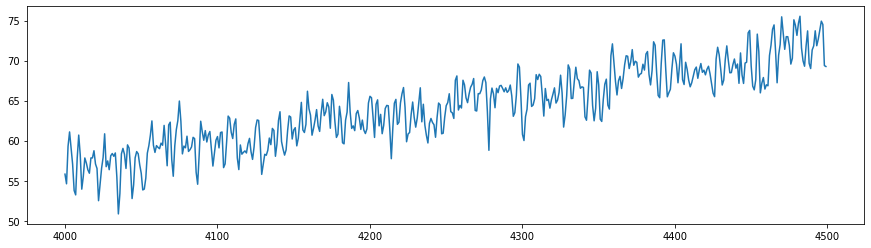

In [ ]:
timeseries, windows_TD, parameters = generate_jumpingmean(window_size)
windows_FD = calc_fft(windows_TD, nfft, norm_mode)

plt.figure(figsize=(15,4))
plt.plot(range(4000,4500),timeseries[4000:4500])
plt.show()

In [ ]:
shared_features_TD = train_AE(windows_TD, intermediate_dim_TD, latent_dim_TD, nr_shared_TD, nr_ae_TD, loss_weight_TD)
shared_features_FD = train_AE(windows_FD, intermediate_dim_FD, latent_dim_FD, nr_shared_FD, nr_ae_FD, loss_weight_FD)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 3, 20)]      0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 3, 1)         21          ['input_17[0][0]']               
                                                                                                  
 dense_33 (Dense)               (None, 3, 0)         0           ['input_17[0][0]']               
                                                                                                  
 tf.concat_8 (TFOpLambda)       (None, 3, 1)         0           ['dense_32[0][0]',               
                                                                  'dense_33[0][0]']        

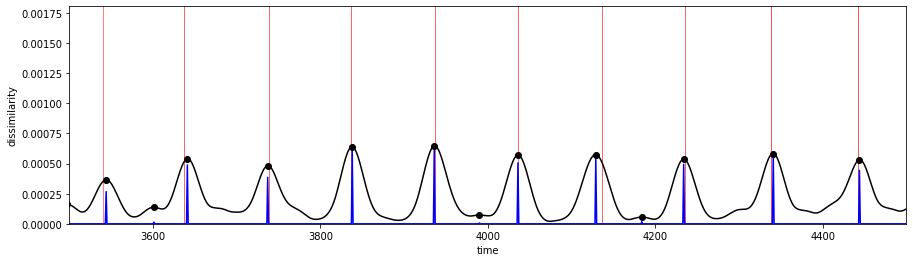

[0.7350432938005095, 0.9528657738760137, 0.9740784834669189]


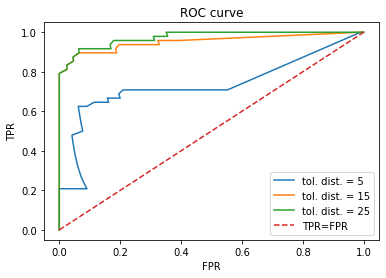

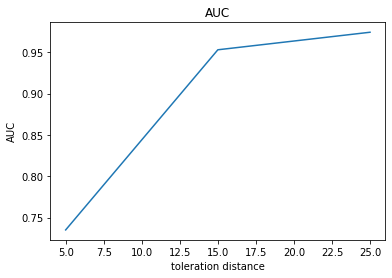

In [ ]:
#we calculate the smoothened dissimilarity measure and the corresponding prominence-based change point scores
dissimilarities = smoothened_dissimilarity_measures(shared_features_TD, shared_features_FD, domain, window_size)
change_point_scores = change_point_score(dissimilarities, window_size)
#parameters for plot
time_start = 3500
time_stop = 4500
plot_prominences = True

plot_cp(dissimilarities, parameters, window_size, time_start, time_stop, plot_prominences)

#parameters for AUC calculation
tol_distances = [5,15,25]
auc = get_auc(dissimilarities,tol_distances, parameters, window_size)

In [ ]:
res = []

for i in range(len(change_point_scores)):
  if change_point_scores[i] != 0:
    res.append(i)

<Figure size 2880x360 with 0 Axes>

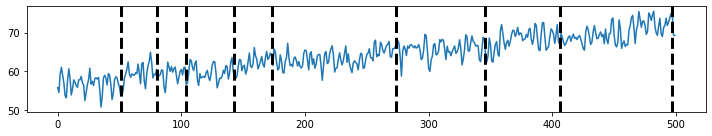

In [ ]:
bkps = []

plt.figure(figsize=(40, 5))
rpt.display(timeseries[4000:4500], bkps, res)

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/dataset/130.csv', on_bad_lines='skip', sep=',', decimal='.')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#столбцы RSN или GR

In [ ]:
data

,MD,CALI,CALI.1,DEVI,DTCO,DTCO.1,DTCO.2,DT,DT.1,DTC,...,RHOB.3,RT,TMP,TMP.1,MD.2,TVD,VCL,TVD.1,Unnamed: 56,Unnamed: 57
0,m,in,in,deg,us/ft,us/ft,us/ft,us/ft,us/ft,us/ft,...,g/cm3,ohm.m,degC,degC,m,m,m3/m3,m,kPa,kPa
1,MD,CALI,CALI_1,DEVI,DT_Corr,DT_spl,DT_spl_1,DT_VINT,DT24,DTC,...,RHOB_2,RT,T_IN,T_OUT,TOPMD,TOPTVD,TTL_GAS,TVD,MW_Pres,MW_Pres_1
2,0,25.4779527559055,25.4779527559055,0,-999.25,-304.5714,-999.25,161.26769563008,-999.25,-304.5714,...,-999.25,-999.25,-999.25,-999.25,0,0,-999.25,0,-999.25,-999.25
3,0.1524,25.4305527559055,25.4305527559055,0,-999.25,-304.5714,-999.25,161.251029399704,-999.25,-304.5714,...,-999.25,-999.25,-999.25,-999.25,0.1524,0.1524,-999.25,0.1524,-999.25,-999.25
4,0.3048,25.4506125984252,25.4506125984252,0,-999.25,-304.5714,-999.25,161.234363169328,-999.25,-304.5714,...,-999.25,-999.25,-999.25,-999.25,0.3048,0.3048,-999.25,0.3048,-999.25,-999.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33560,5114.2392,8.533118,8.533118,0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,2.64508,-999.25,10.846028,42.696168,5114.2392,5114.2392,0.009116,5114.2392,2881766.964398,102438.32058
33561,5114.3916,8.531618,8.531618,0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,2.644792,-999.25,10.954994,42.778464,5114.3916,5114.3916,0.00875,5114.3916,2881852.838615,103162.493831
33562,5114.544,8.532953,8.532953,0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,2.644828,-999.25,11.0222,42.87516,5114.544,5114.544,0.008392,5114.544,2881938.712829,104030.161462
33563,5114.6964,8.533504,8.533504,0,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,...,2.644795,-999.25,11.029612,42.963056,5114.6964,5114.6964,-4.812106,5114.6964,2882024.587047,104233.999616


In [ ]:
df = data[["RSN"]]
df = df.iloc[2:, 0:2]


In [ ]:
df

,RSN
2,-999.25
3,-999.25
4,-999.25
5,-999.25
6,-999.25
...,...
33560,-999.25
33561,-999.25
33562,-999.25
33563,-999.25


In [ ]:
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33563 entries, 2 to 33564
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RSN     33563 non-null  float64
dtypes: float64(1)
memory usage: 262.3 KB


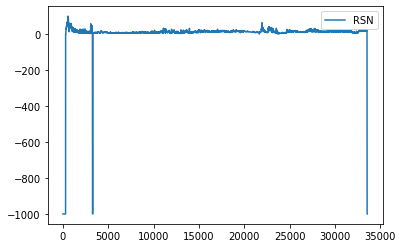

In [ ]:
df.plot()

In [ ]:
window_size = 20
domain = "both" #choose from: TD (time domain), FD (frequency domain) or both

#parameters TD
intermediate_dim_TD=0
latent_dim_TD=1 #h^TD in paper
nr_shared_TD=1 #s^TD in paper
K_TD = 2 #as in paper
nr_ae_TD= K_TD+1 #number of parallel AEs = K+1
loss_weight_TD=1 #lambda_TD in paper

#parameters FD
intermediate_dim_FD=10
latent_dim_FD=1 #h^FD in paper
nr_shared_FD=1 #s^FD in paper
K_FD = 2 #as in paper
nr_ae_FD=K_FD+1 #number of parallel AEs = K+1
loss_weight_FD=1 #lambda^FD in paper
nfft = 30 #number of points for DFT
norm_mode = "timeseries" #for calculation of DFT, should the timeseries have mean zero or each window?

In [ ]:
#note: loaded data can be preprocessed using utils.ts_to_windows and utils.combine_ts


In [ ]:
timeseries = df.values[5000:6000]
stride = 1

windows_TD = ts_to_windows(timeseries, 0, window_size, stride)

windows_TD = np.reshape(windows_TD, (981, 20))

windows_FD = calc_fft(windows_TD, nfft, norm_mode)



In [ ]:
shared_features_TD = train_AE(windows_TD, intermediate_dim_TD, latent_dim_TD, nr_shared_TD, nr_ae_TD, loss_weight_TD)
shared_features_FD = train_AE(windows_FD, intermediate_dim_FD, latent_dim_FD, nr_shared_FD, nr_ae_FD, loss_weight_FD)

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 3, 20)]      0           []                               
                                                                                                  
 dense_40 (Dense)               (None, 3, 1)         21          ['input_21[0][0]']               
                                                                                                  
 dense_41 (Dense)               (None, 3, 0)         0           ['input_21[0][0]']               
                                                                                                  
 tf.concat_10 (TFOpLambda)      (None, 3, 1)         0           ['dense_40[0][0]',               
                                                                  'dense_41[0][0]']        

Визуализация результатов обучения и работы модели на реальных данных

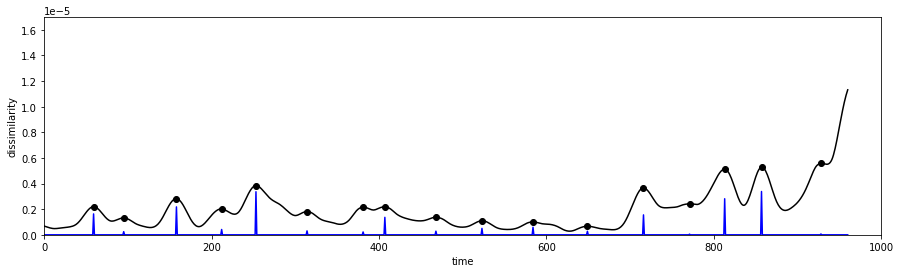

In [ ]:
#we calculate the smoothened dissimilarity measure and the corresponding prominence-based change point scores
dissimilarities = smoothened_dissimilarity_measures(shared_features_TD, shared_features_FD, domain, window_size)
change_point_scores = change_point_score(dissimilarities, window_size)
#parameters for plot
time_start = 0
time_stop = 1000
plot_prominences = True

plot_cp_custom(dissimilarities, window_size, time_start, time_stop, plot_prominences)

In [ ]:
res = []

for i in range(len(change_point_scores)):
  if change_point_scores[i] != 0:
    res.append(i)


In [ ]:
signal = df.values[5000:6000]
bkps = []

<Figure size 2880x360 with 0 Axes>

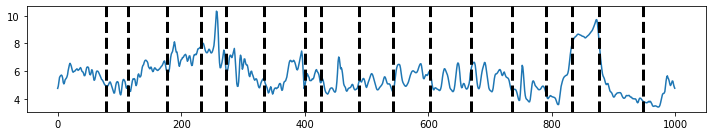

In [ ]:
plt.figure(figsize=(40, 5))
rpt.display(signal, bkps, res)

plt.show()

Для сравнения, построим разбиение с помощью библиотеки ruptures

<Figure size 2880x360 with 0 Axes>

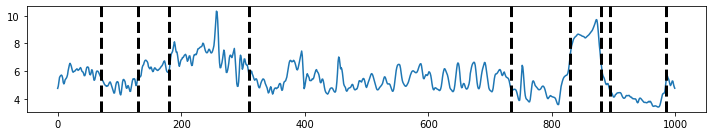

In [ ]:
# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
plt.figure(figsize=(40, 5))
rpt.display(signal, bkps, result)

plt.show()